# T<sub>2</sub> Hahn Characterization

The purpose of the $T_2$ Hahn Echo experiment is to determine $T_2$ qubit property. 

In this experiment, we would like to get a more precise estimate of the qubit's decay time. $T_2$ represents the amount of time required for the transverse magnetization to fall to approximately 37% ($\frac{1}{e}$) of its initial value.

Since the qubit exposed to other noises (like $T_1$), we are using a $Rx(\pi)$ pulse for decoupling and to solve our inaccuracy for the qubit frequency estimation.

In [1]:
import qiskit
from qiskit.utils import apply_prefix
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

The circuit used for the experiment comprises the following:

    1. Rx gate
    2. delay
    3. measurement

The user provides as input a series of delays and the time unit for the delays, e.g., seconds, milliseconds, etc. During the delay, we expect the qubit to precess about the z-axis. Because of the echo gate ($Rx(\pi)$) for each echo, the angle will converge after the delay gates as following $\theta_{new} = \theta_{old} + \pi$. By varying the extension of the delays, we get a series of decaying measurements. We can draw the graph of the resulting function and can analytically extract the desired values.

In [2]:
# set the computation units to microseconds
unit = "us"  # microseconds
qubit = 0
# set the desired delays
conversion_factor = 1e-6
delays = list(range(1, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]

In [3]:
# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(qubit, delays)
print(exp1.circuits()[0])

     ┌─────────┐┌─────────────────┐┌───────┐┌─────────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└─────────────────┘└───────┘└─────────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════╩═
                                                                           0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [4]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob


estimated_t2hahn = 20
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[20],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)
print(conversion_factor)

1e-06


The resulting graph will have the form:
$f(t) = a \cdot e^{-\frac{t}{T_2}}+ b$
where *t* is the delay and $T_2$ is the decay factor.
`conversion_factor` is a scaling factor that depends on the measurement units used. It is 1E-6 here, because the unit is microseconds.

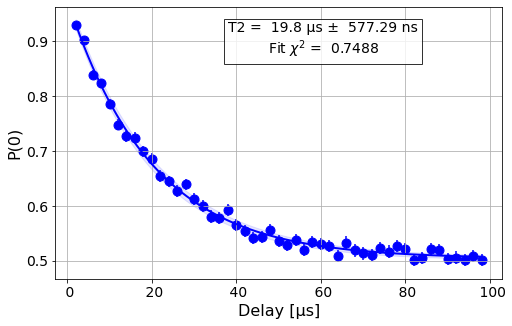

In [5]:
dt_factor = apply_prefix(1, unit)

# exp1.set_analysis_options(p0={"amp": 0.5, "tau": 20 * conversion_factor, "base": 0.5})

expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [6]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.73150237e-01 5.03648507e-01 1.98283007e-05] ± [5.15527131e-03 3.03978270e-03 5.77293057e-07]
- χ²: 0.7488240853426228
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 1.9828300679956625e-05 ± 5.772930568055365e-07 s
- χ²: 0.7488240853426228
- quality: good
- device_components: ['Q0']
- verified: False


### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameters $A$ and $B$ is $0.5$.In this experiment, `t2hahn` is the parameter of interest. Good estimate for it is the value computed in previous experiments on this qubit or a similar value computed for other qubits.

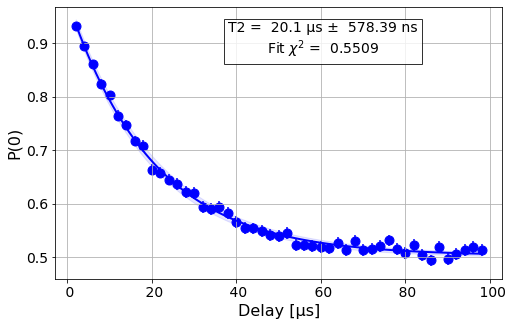

In [7]:
exp_with_p0 = T2Hahn(qubit, delays)
exp_with_p0.set_analysis_options(p0={"amp": 0.5, "tau": 20 * conversion_factor, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [8]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.78978431e-01 5.02409209e-01 2.01192655e-05] ± [5.09032092e-03 3.07792331e-03 5.78387141e-07]
- χ²: 0.5509343846546172
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.011926549231594e-05 ± 5.783871411742618e-07 s
- χ²: 0.5509343846546172
- quality: good
- device_components: ['Q0']
- verified: False


### Number of echoes
The user can provide the number of echoes that the circuit will perform. This will determine the amount of delay and echo gates. As the number of echoes increase, the total time of the circuit will grow. The echoes decrease the effects of $T_{1}$ noise and frequency inaccuracy estimation. Due to that, Hahn Echo experiment let us estimate $T_{2}$ better.
Note, that the delay time provided is the for each delay in the circuit and not the total time.

In [9]:
import numpy as np
# set the computation units to microseconds
unit2 = "us"  # microseconds
qubit2 = 0

# set the desired delays
conversion_factor = 1e-6

delays2 = np.append(
                    (np.linspace(1.0, 10.0, num=37)).astype(float),
                    (np.linspace(10.5, 45.0, num=70)).astype(float),
                )
delays2 = [float(_) * conversion_factor for _ in delays2]
num_echoes = 4


# Create a T2Hahn experiment. Print the first circuit as an example
exp2 = T2Hahn(qubit2, delays2, num_echoes=num_echoes)
print(exp2.circuits()[0])


     ┌─────────┐┌─────────────────┐┌───────┐┌─────────────────┐»
  q: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├»
     └─────────┘└─────────────────┘└───────┘└─────────────────┘»
c: 1/══════════════════════════════════════════════════════════»
                                                               »
«     ┌─────────────────┐┌───────┐┌─────────────────┐┌─────────────────┐»
«  q: ┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Delay(1e-06[s]) ├»
«     └─────────────────┘└───────┘└─────────────────┘└─────────────────┘»
«c: 1/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌───────┐┌─────────────────┐┌─────────────────┐┌───────┐»
«  q: ┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├»
«     └───────┘└─────────────────┘└─────────────────┘└───────┘»
«c: 1/════════════════════════════════════════════════════════»
«                                                

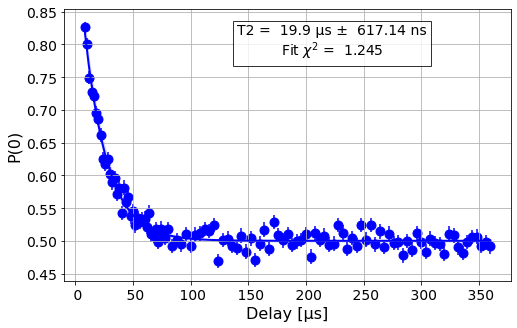

In [10]:

from qiskit_experiments.test.t2hahn_backend import T2HahnBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob


estimated_t2hahn2 = 20
# The behavior of the backend is determined by the following parameters
backend2 = T2HahnBackend(
    t2hahn=[20],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor,
)


dt_factor2 = apply_prefix(1, unit2)

# exp2.set_analysis_options(p0={"amp": 0.5, "tau": 20 * conversion_factor, "base": 0.5})

expdata2 = exp2.run(backend=backend2, shots=2000)
expdata2.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata2.figure(0))

###  $T_{2}$ v.s  $T_{2}^{\ast}$
This experiment purpose is to give a better estimation for the dephasing noise. In Ramsey experiment, we can estimate $T_{2}^{\ast}$ but this is not truly the dephasing noise as the information is not lost.
The $\ast$ indicates that $T_{2}^{\ast}$ is sensitive to inhomogeneous broadening. By using echo pulse ($Rx(\pi)$) we can reduce the effect of the inhomogeneous broadening and get better estimation.

In [11]:
import qiskit
from qiskit_experiments.library import T2Ramsey
from qiskit_experiments.test.t2ramsey_backend import T2RamseyBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob

# set the computation units to microseconds
unit_ramsey = "us"  # microseconds
qubit_ramsey = 0
# set the desired delays
delays_ramsey = list(range(1, 50, 1))

conversion_factor_ramsey = 1e-6
# defining backend for the experiment
backend_ramsey = T2RamseyBackend(
    p0={
        "A": [0.5],
        "T2star": [20.0],
        "f": [100100],
        "phi": [0.0],
        "B": [0.5],
    },
    initial_prob_plus=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
    conversion_factor=conversion_factor_ramsey,
)

# Create a T2Ramsey experiment. Print the first circuit as an example
exp1_ramsey = T2Ramsey(qubit_ramsey, delays_ramsey, unit=unit_ramsey, osc_freq=1e5, backend=backend_ramsey)

# Run the experiment
expdata1_ramsey = exp1_ramsey.run(backend=backend_ramsey, shots=2000)
expdata1_ramsey.block_for_results()  # Wait for job/analysis to finish.

# Printing a circuit for example
print(exp1_ramsey.circuits()[0])

     ┌───┐┌─────────────────┐┌─────────┐ ░ ┌───┐ ░ ┌─┐
  q: ┤ H ├┤ Delay(1e-06[s]) ├┤ Rz(π/5) ├─░─┤ H ├─░─┤M├
     └───┘└─────────────────┘└─────────┘ ░ └───┘ ░ └╥┘
c: 1/═══════════════════════════════════════════════╩═
                                                    0 


We can see that while both backends have $T_2 = 20 [\mu s]$, the estimation of the Hahn Echo experiment is better.

In [12]:
import qiskit.tools.jupyter
%qiskit_copyright